In [1]:
import pandas as pd
import numpy as np 
from datetime import timedelta 
import xgboost as xgb

In [2]:
train_df = pd.read_csv('ais_train.csv', sep = "|")

In [3]:
vessels_df = pd.read_csv('vessels.csv', sep = '|')

In [4]:
ports_df = pd.read_csv('ports.csv', sep = '|')

In [5]:
test_df = pd.read_csv('ais_test.csv', sep = ',')

## Preprocessing

In [6]:
# Convert 'time' to datetime
train_df['time'] = pd.to_datetime(train_df['time'])
test_df['time'] = pd.to_datetime(test_df['time'])

# Convert 'etaRaw' to datetime

# Ensure 'vesselId' is string
train_df['vesselId'] = train_df['vesselId'].astype(str)
test_df['vesselId'] = test_df['vesselId'].astype(str)

# Convert 'time' to numeric format
train_df['time_numeric'] = (train_df['time'] - train_df['time'].min()).dt.total_seconds()
test_df['time_numeric'] = (test_df['time'] - train_df['time'].min()).dt.total_seconds()

## Principle component analysis 

In [7]:
from sklearn.decomposition import PCA

X = train_df.drop(columns = ['vesselId', 'time', 'etaRaw', 'portId'])
pca = PCA(n_components=2)
pca.fit(X)


PCA(n_components=2)

In [57]:
import matplotlib.pyplot as plt
x_pca = pca.transform(X)
df_pca1 = pd.DataFrame(x_pca,
                       columns=['PC{}'.
                       format(i+1)
                        for i in range(2)])
print(df_pca1)

pca.explained_variance_

                  PC1         PC2
0        5.627999e+06   14.927141
1        5.627988e+06   74.386893
2        5.627919e+06  -89.775712
3        5.627833e+06  -89.191106
4        5.627793e+06   52.687174
...               ...         ...
1522060 -5.431123e+06    6.546538
1522061 -5.431124e+06 -230.996261
1522062 -5.431124e+06  132.234378
1522063 -5.431124e+06 -239.952567
1522064 -5.431124e+06  229.290741

[1522065 rows x 2 columns]


array([1.01602220e+13, 1.64023365e+04])

In [58]:
X = train_df.drop(columns = ['vesselId', 'portId', 'etaRaw', 'navstat','heading', 'cog', 'time', 'rot'])
y_data = {'longitude':X['longitude'][1:], 'latitude': X['latitude'][1:], 'sog':X['sog'][1:]}
y = pd.DataFrame(data = y_data)
X = X[:-1]
print(len(X), len(y[1:]))
display(X.head())
display(y.head())

1522064 1522063


,sog,latitude,longitude,time_numeric
0,0.7,-34.74370,-57.85130,0.0
1,0.0,8.89440,-79.47939,11.0
2,11.0,39.19065,-76.47567,80.0
3,0.0,-34.41189,151.02067,166.0
4,19.7,35.88379,-5.91636,206.0


,longitude,latitude,sog
1,-79.47939,8.89440,0.0
2,-76.47567,39.19065,11.0
3,151.02067,-34.41189,0.0
4,-5.91636,35.88379,19.7
5,-110.32727,24.27431,0.0


In [59]:
vessel_data = train_df['vesselId'][0]

X = train_df.drop(columns = ['vesselId', 'portId', 'etaRaw', 'navstat', 'cog', 'sog', 'heading','time'])
y_data = {'longitude': X['longitude'][1:], 'latitude': X['latitude'][1:], 'rot':X['rot'][1:]}
y = pd.DataFrame(data = y_data)

print(np.sum(np.isnan(y['longitude'])), np.sum(np.isnan(X['longitude'][1:])))
print(np.sum(np.isnan(y['latitude'])), np.sum(np.isnan(X['latitude'][1:])))



0 0
0 0


In [11]:
vessel = train_df['vesselId'][0]
vessel_data = train_df[train_df['vesselId'] == vessel]
display(vessel_data)

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId,time_numeric
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,0.0
2672,2024-01-01 06:09:08,92.8,14.2,0,90,0,01-09 23:00,-35.16787,-56.77210,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,22123.0
2947,2024-01-01 06:38:19,90.5,14.3,0,88,0,01-09 23:00,-35.16863,-56.63185,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,23874.0
3093,2024-01-01 06:58:55,88.2,14.3,0,86,0,01-09 23:00,-35.16805,-56.53190,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,25110.0
3140,2024-01-01 07:15:56,88.3,12.3,0,86,0,01-09 23:00,-35.16715,-56.45306,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f,26131.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1444134,2024-05-01 11:34:58,230.3,14.8,0,229,0,05-02 12:00,34.76486,129.25384,61e9f3a8b937134a3c4bfdf7,61d37a551366c3998241d97f,10496073.0
1444291,2024-05-01 11:55:22,231.5,14.9,0,230,0,05-02 12:00,34.71258,129.17443,61e9f3a8b937134a3c4bfdf7,61d37a551366c3998241d97f,10497297.0
1444452,2024-05-01 12:16:22,227.4,15.2,0,225,0,05-02 12:00,34.65578,129.09349,61e9f3a8b937134a3c4bfdf7,61d37a551366c3998241d97f,10498557.0
1444523,2024-05-01 12:36:22,226.3,15.4,0,223,0,05-02 12:00,34.59684,129.01917,61e9f3a8b937134a3c4bfdf7,61d37a551366c3998241d97f,10499757.0


In [88]:
models = {}
X = train_df.drop(columns =  ['portId', 'etaRaw', 'navstat', 'cog', 'time', 'heading', 'rot'])
y = X.drop(columns = ['time_numeric'])
vessels = X['vesselId'].unique()
for count, vessel in enumerate(vessels):
    vessel_data = X[X['vesselId'] == vessel]
    y_data = y[y['vesselId'] == vessel].drop(columns = 'vesselId')
    vessel_data = vessel_data.drop(columns = ['vesselId'])
    print(count, len(vessels), end = '\r')
    model = xgb.XGBRegressor().fit(vessel_data[:-1],  y_data[1:])

    models[vessel] = model


/Users/markussandnes/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:09:15] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/common/error_msg.cc:52: Empty dataset at worker: 0
  warnings.warn(smsg, UserWarning)


In [108]:
X_global = train_df.drop(columns = ['vesselId', 'portId', 'etaRaw', 'navstat', 'cog',  'time', 'heading'])
y_global_data = {'longitude':X_global['longitude'][1:], 'latitude': X_global['latitude'][1:], 'sog':X_global['sog'][1:],'rot':X_global['rot'][1:]}
y_global = pd.DataFrame(data = y_global_data)
X_global = X_global[:-1]
display(X_global)   
display(y)   

,sog,rot,latitude,longitude,time_numeric
0,0.7,0,-34.74370,-57.85130,0.0
1,0.0,-6,8.89440,-79.47939,11.0
2,11.0,0,39.19065,-76.47567,80.0
3,0.0,0,-34.41189,151.02067,166.0
4,19.7,0,35.88379,-5.91636,206.0
...,...,...,...,...,...
1522059,15.2,0,51.37640,4.05389,11059122.0
1522060,13.4,0,52.19131,-5.82223,11059122.0
1522061,17.1,0,38.96142,-12.00502,11059123.0
1522062,14.9,-1,49.71372,-5.22042,11059123.0


,sog,latitude,longitude,vesselId
0,0.7,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7
1,0.0,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f
2,11.0,39.19065,-76.47567,61e9f436b937134a3c4c0131
3,0.0,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77
4,19.7,35.88379,-5.91636,61e9f41bb937134a3c4c0087
...,...,...,...,...
1522060,13.4,52.19131,-5.82223,clh6aqawa0002gh0zypfa5dut
1522061,17.1,38.96142,-12.00502,61e9f3aeb937134a3c4bfe43
1522062,14.9,49.71372,-5.22042,61e9f43db937134a3c4c0169
1522063,18.7,38.27895,10.78280,61e9f469b937134a3c4c029b


In [90]:
global_model = xgb.XGBRegressor().fit(X_global, y_global)

In [127]:
# Predict positions
lat_pred = []
long_pred = []
predictions = []
last_position = {}

for index, row in test_df.iterrows():
    vessel = row['vesselId']
    time_numeric = row['time_numeric']
    if(vessel in last_position):
        sog,lat,long = last_position[vessel]
    else: 
        long = np.array(train_df[train_df['vesselId']  == vessel]['longitude'])[-1]
        lat = np.array(train_df[train_df['vesselId']  == vessel]['latitude'])[-1]
        sog = np.array(train_df[train_df['vesselId']  == vessel]['sog'])[-1]
    
    if vessel in models:
        model = models[vessel]
    else:
        model = global_model
    print(index, end = '\r')
    X_data = {'sog': sog, 'latitude':lat, 'longitude':long, 'time_numeric':time_numeric}
    X = pd.DataFrame(data = X_data, index = [0])
    prediction = model.predict(X)
    last_position[vessel] = prediction[0]
    lat_pred.append(prediction[0][1])
    long_pred.append(prediction[0][2])
    predictions.append[prediction[0]]

In [128]:
lat_pred_rounded = np.round(lat_pred,6)
long_pred_rounded = np.round(long_pred,6)

test_df['latitude_predicted'] = lat_pred
test_df['longitude_predicted'] = long_pred
submission = test_df[['ID', 'longitude_predicted','latitude_predicted']].copy()
submission.to_csv('predictions_xgb.csv', index=False)

In [129]:
pred1 = pd.read_csv('predictions.csv', sep = ',')
pred2 = pd.read_csv('predictions_xgb.csv', sep = ',')

print(np.mean(pred1['latitude_predicted']))
print(np.mean((pred1['longitude_predicted'])))

print(np.mean(pred2['latitude_predicted']))
print(np.mean((pred2['longitude_predicted'])))

print(max(pred1['longitude_predicted'] - pred2['longitude_predicted']))

38.355458452971654
9.677271618676166
38.615587305216565
8.200875515846384
296.48807999999997


[[ 4.3442380e+01 -3.8231600e+00  4.9000000e+02]
 [ 4.3442370e+01 -3.8230900e+00  1.2100000e+03]
 [ 4.3442400e+01 -3.8232100e+00  2.6510000e+03]
 ...
 [ 5.1583780e+01 -5.8519200e+00  1.1049538e+07]
 [ 5.1651730e+01 -5.8492700e+00  1.1050584e+07]
 [ 5.2111050e+01 -5.8134100e+00  1.1057852e+07]]
[[43.44237 -3.82309]
 [43.4424  -3.82321]
 [43.44238 -3.82314]
 ...
 [51.65173 -5.84927]
 [52.11105 -5.81341]
 [52.19131 -5.82223]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1257.7501
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1133.4336
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1023.9790
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 926.8167
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 834.5170
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 742.7861
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 669.3854
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 591.3431
Epoch 9/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 527.9366
Epoch 10/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 466.9424


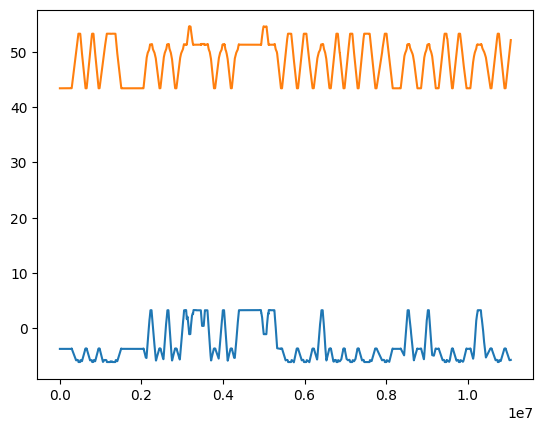

In [91]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

vessel = train_df['vesselId'][11]

vessel_data = train_df[train_df['vesselId'] == vessel ]

vessel_data = vessel_data.drop(columns = ['time', 'sog', 'cog', 'rot', 'heading', 'navstat', 'etaRaw', 'portId', 'vesselId'])
y = np.array(vessel_data[1:].drop(columns = ['time_numeric']))
X = np.array(vessel_data[:-1])

print(X)
print(y)

def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    # Iterate over the dataset and create sequences
    for i in range(len(X) - time_steps):
        # Create input sequence of shape (time_steps, features)
        X_seq.append(X[i:i + time_steps])
        # The target y will be the next latitude and longitude after the last timestep
        y_seq.append(y[i + time_steps])
    
    # Convert the lists to numpy arrays
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, 10)
plt.plot(vessel_data['time_numeric'], vessel_data['longitude'])
plt.plot(vessel_data['time_numeric'], vessel_data['latitude'])

model = Sequential()

model.add(LSTM(50, input_shape = (X_seq.shape[1], X_seq.shape[2])))
model.add(Dense(2))
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(X_seq, y_seq, epochs = 10)

In [92]:
prediction = model.predict(X_seq)

173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


ValueError: x and y must have same first dimension, but have shapes (5542,) and (5535,)

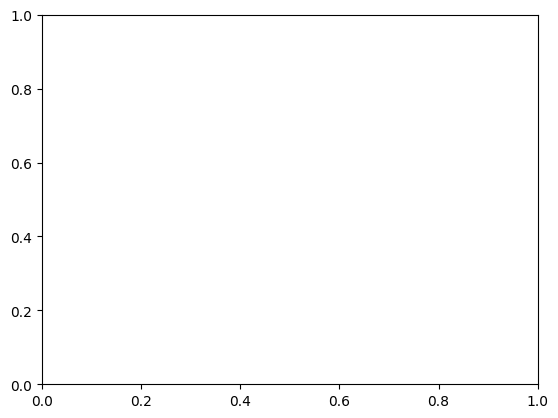

In [93]:
vessel_data['time_numeric']
plt.plot(vessel_data['time_numeric'][:-4], prediction[:,1])